<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

# cGAN
Code based on https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

## Problem definition
We have a dataset like MNIST, of images $x$ and class labels $y$.

The objective is to train a **Generator**, a neural network $G$ whose:
* input is a fixed-size random latent vector $z$ and a class label $y$;
* output is a generated hand-written image $x_{fake}$ mimicking real datapoints.

$$ G(z,y) = x_{fake}, \quad \quad z \sim \mathcal{N}(0, I) $$

##  cGAN architecture
We will train networks based on [cGAN](https://arxiv.org/pdf/1411.1784.pdf) and [DCGAN](https://arxiv.org/abs/1511.06434).

Together with the Generator, we train a **Discriminator** network $D$, which classifies images as real or fake (generated). That is, for $D$:
* input is an image (real or fake) $x$ and a class label $y$;
* output is the predicted probability of $x$ being a real image for class $y$, rather than a fake one.

$$ D(x, y) \in [0,1] $$

cGAN is trained using the adversarial objective, making two steps for each mini-batch of $(x,y)$ of size $B$:
1. In the first step, weights of the Discriminator are trained for binary classification:
    * We compute $D(x)$ and the *real loss* for them to be classified as $B$ real images.
    * We sample a batch of size $B$ of $z \sim \mathcal{N}(0,I)$ and class labels $y$ (uniformly), and compute $x_{fake} = G(z, y)$.
    * We compute $D(x_{fake})$ and the *fake loss* for them to be classified as $B$ fake images.
    * The discriminator loss is the average of the above losses ($\frac{1}{2B}$ of total).
    * Gradients through $D$ are computed and used to update the weights of $D$ with its optimizer.
      (Since gradients through $G$ are not needed for that step, we use `x_fake.detach()` before giving it to $D$).
2. In the second step, weights of the Generator are trained to fool the Discriminator:
    * We sample a fresh batch of size $2B$ of $z \sim \mathcal{N}(0,I)$ and class labels $y$ (uniformly), and compute $x_{fake} = G(z, y)$.
    * We compute $D(x_{fake})$ and the *generator loss* for them to be classified as $B$ real images.
    * Gradients through $D$ and $G$ are computed and used to update the weights of $G$ with its optimizer (leaving $D$ unchanged).

This *generator loss* uses the ["log-D" trick](https://arxiv.org/pdf/2009.00169v1.pdf):
instead of using the *negative of the discriminator loss*,
which would *maximize* the binary cross-entropy loss for classification as *fake* images,
we *minimize* the binary cross-entropy loss for classification as *real* images.
The former could easily saturate early, when the generator is very bad ($D(x_{fake}) \simeq 0$).

Some technical remarks:
1. Image class labels $y$ are inserted as 1-dimensional tensors (containing integers 0-9) and passed through the [pytorch Embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) to construct embeddings:
    * Its parameters are a random matrix `(num_embeddings=10, embedding_dim=E)` (unit normal i.i.d.).
    * The `forward` operation takes an index in `0..9` and returns the corresponding row.
    * Equivalently, it just multiplies one-hot encodings by that matrix.
    * If the input is any tensor $y$ of such indices, the result has shape `(*y.shape, E)`.
2. These embeddings of class labels $y$ are then concatenated channelwise with images (in $D$) or samples from the gaussian distribution (in $G$).
3. They are then processed with 2D convolutions and transpose 2D convolutions.

## Tasks

1. Read the code.
2. Complete the definitions of all losses in the Trainer `train_step` method.
2. Run the pipeline, verify that:
    1. The generator creates decent fake images.
    2. The quality of generated images improves over time.

4. Visualize a line in latent space, that is, interpolate between generated images:
    1. Fix a vector of class label $y$ that includes each class 0..9 three times.
    2. Sample two vectors in latent space: $z_1, z_2 \sim \mathcal{N}(0,I)$.
    3. Generate a sequence of 50 images
      based on $y$ and on 50 equidistant points $z$ on the segment with endpoints $z_1, z_2$.
    4. Visualize the "transition" of the sequence.

5. Modify the code to check how the "transition" between two samples change over the training time.



In [1]:
from pathlib import Path

import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.accelerator
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils
from IPython.display import HTML
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import v2
from tqdm import tqdm

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# Check for CUDA / MPS (Apple) / XPU (Intel) / ... accelerator.
# This does not detect XLA devices (Google TPUs), they'd need separate checks.
device = (
    torch.accelerator.current_accelerator(check_available=True)
    or torch.device("cpu")  #
)
use_accel = device != torch.device("cpu")
print(use_accel, device)

True cuda


# Dataset and dataloader

In [3]:
data_dir = Path("./data")
transform = v2.Compose(
    [v2.ToImage(), v2.ToDtype(torch.float32, scale=True), v2.Normalize((0.5,), (0.5,))]
)
inverse_transform = v2.Compose(
    [
        v2.Normalize((-1.0,), (2.0,)),
        v2.ToDtype(torch.uint8, scale=True),
        v2.ToPILImage(),
    ]
)

dataset = MNIST(data_dir, transform=transform, download=True)
# Feel free to use FashionMNIST instead.
# dataset = FashionMNIST(data_dir, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.77MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.28MB/s]


In [4]:
dataloader = DataLoader(
    dataset, batch_size=128, shuffle=True, num_workers=2, persistent_workers=True
)

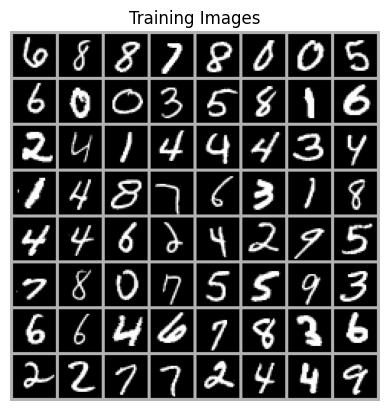

In [5]:
def plot_images(image_batch: Tensor, title: str, scale: float = 0.6) -> None:
    """Show a batch of normalized images of shape (B, C, H, W) as a grid."""
    n_images = image_batch.shape[0]
    n_columns = int(np.ceil(np.sqrt(n_images)))
    n_rows = int(np.ceil(n_images / n_columns))
    plt.figure(figsize=(n_columns * scale, n_rows * scale))
    plt.title(title)
    image_grid = torchvision.utils.make_grid(
        image_batch, nrow=n_columns, padding=2, pad_value=0.4
    )
    plt.imshow(inverse_transform(image_grid))
    plt.axis("off")
    plt.show()


# Plot some training images.
real_image_batch, real_label_batch = next(iter(dataloader))
plot_images(real_image_batch[:64], "Training Images")

In [6]:
# Look at basic dataset statistics.
print(
    real_image_batch.shape,
    real_image_batch.min().item(),
    real_image_batch.max().item(),
)
print(
    real_label_batch.shape,
    real_label_batch.min().item(),
    real_label_batch.max().item(),
)

torch.Size([128, 1, 28, 28]) -1.0 1.0
torch.Size([128]) 0 9


# Generator

In [7]:
# Size of z latent vector (i.e. size of generator input).
z_dim = 98

In [8]:
class Generator(nn.Module):
    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.base_shape = 7, 7
        bH, bW = self.base_shape
        self.label_embedding = nn.Embedding(num_classes, bH * bW)
        self.z_channels = int(np.ceil(z_dim / (bH * bW)))
        self.linear = nn.Linear(z_dim, self.z_channels * bH * bW)
        self.upconvolutions = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=self.z_channels + 1,
                out_channels=64,
                kernel_size=5,
                stride=2,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                in_channels=64, out_channels=32, kernel_size=4, padding=0, bias=False
            ),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                in_channels=32, out_channels=32, kernel_size=4, padding=0, bias=False
            ),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                in_channels=32, out_channels=16, kernel_size=4, padding=0, bias=False
            ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0, bias=False
            ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
        )
        self.convolutions = nn.Sequential(
            nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16, out_channels=1, kernel_size=3, padding=1, bias=False
            ),
            nn.Tanh(),
        )

    def forward(self, z: Tensor, y: Tensor) -> Tensor:
        """
        Args:
        - z: latent vector, shape (B, z_dim), where B is batch size.
        - y: label, as an integer between 0 and num_classes - 1, shape (B,).

        Returns: image of shape (B, C=1, H=28, W=28), range -1..1.
        """
        B = z.shape[0]
        assert y.shape == (B,), f"Batch size mismatch: {z.shape=} {y.shape=}"
        bH, bW = self.base_shape

        z = self.linear(z)  # (B, z_channels * bH * bW)
        z = z.view(B, self.z_channels, bH, bW)

        y = self.label_embedding(y)  # (B, bH * bW)
        y = F.relu(y)
        y = y.view(B, 1, bH, bW)

        x = torch.cat([z, y], dim=1)  # (B, z_channels + 1, bH, bW)
        x = self.upconvolutions(x)
        x = self.convolutions(x)
        return x

torch.Size([16, 1, 28, 28])


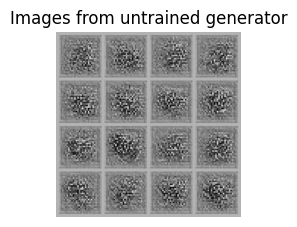

In [9]:
# Create the generator.
netG = Generator().to(device)

# Example execution.
fixed_batch_size = 16
fixed_noise = torch.randn(size=(fixed_batch_size, z_dim), device=device)
fixed_y = torch.randint(low=0, high=10, size=(fixed_batch_size,), device=device)
example_generations = netG(fixed_noise, fixed_y)
print(example_generations.shape)
plot_images(example_generations, "Images from untrained generator")

# Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.embedding = nn.Embedding(num_classes, 28 * 28)
        self.convolutions = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=4, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=7, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
        )
        self.output = nn.Sequential(nn.Linear(128, 1), nn.Sigmoid())

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        """
        Args:
          x: image to be discriminated, shape (B, C=1, H=28, W=28)
          y: purported label, shape (B,), as integers between 0 and num_classes - 1.

        Returns: probability of x being a true image for label y, shape (B,).
        """
        B, C, H, W = x.shape
        assert y.shape == (B,), f"Batch size mismatch: {x.shape=} {y.shape=}"
        y = self.embedding(y)  # shape (B, 28 * 28)
        y = y.view(B, 1, H, W)  # (B, 1, 28, 28)

        x = torch.cat([x, y], dim=1)  # (B, C + 1, 28, 28)
        x = self.convolutions(x)  # (B, 128, 1, 1)
        x = x.view(B, 128)  # (B, 128)
        x = self.output(x)  # (B, 1)
        return x.squeeze(dim=1)

In [11]:
# Create the Discriminator.
netD = Discriminator().to(device)

# Example execution.
netD(example_generations, fixed_y)

tensor([0.5585, 0.4613, 0.5401, 0.6105, 0.4793, 0.4165, 0.4849, 0.4282, 0.4482,
        0.5784, 0.5436, 0.6608, 0.6086, 0.4493, 0.6012, 0.5019],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

# Trainer

In [12]:
# Create a fixed batch of latent vectors for visualization.
fixed_batch_size = 64
fixed_noise = torch.randn(size=(fixed_batch_size, z_dim), device=device)
fixed_y = torch.randint(low=0, high=10, size=(fixed_batch_size,), device=device)

# Establish convention for real and fake labels during training.
REAL_LABEL = 1.0
FAKE_LABEL = 0.0

In [ ]:
class Trainer:
    def __init__(self, netG: nn.Module, netD: nn.Module) -> None:
        self.netG = netG
        self.netD = netD

        # Setup Adam optimizers for both G and D.
        self.optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def train(self, num_epochs: int = 5) -> tuple[list[Tensor], dict[str, list[float]]]:
        # Lists to keep track of progress.
        generated_image_batches = list[Tensor]()
        all_metrics = dict[str, list[float]]()
        iters: int = 0

        try:
            for epoch in range(num_epochs):
                self.progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")
                for i, (real_x_images, real_y_labels) in enumerate(self.progress_bar):
                    real_x_images = real_x_images.to(device)  # shape (B, 1, 28, 28)
                    real_y_labels = real_y_labels.to(device)  # shape (B,)
                    metrics = self.train_step(real_x_images, real_y_labels)
                    for key, value in metrics.items():
                        if key not in all_metrics:
                            all_metrics[key] = list[float]()
                        all_metrics[key].append(value)

                    # Check how the generator is doing by saving G's output on fixed_noise.
                    iters += 1
                    if (iters % 100 == 2):
                        netG.eval()
                        with torch.no_grad():
                            image_batch = netG(fixed_noise, fixed_y).detach().cpu()
                        generated_image_batches.append(image_batch)

            netG.eval()
            with torch.no_grad():
                image_batch = netG(fixed_noise, fixed_y).detach().cpu()
            generated_image_batches.append(image_batch)
        except KeyboardInterrupt:
            print("Training interrupted.")

        return generated_image_batches, all_metrics

    def train_step(self, real_x_images: Tensor, real_y_labels: Tensor) -> dict[str, float]:
        self.netG.train()
        self.netD.train()
        B = real_x_images.shape[0]

        ############################
        # (1) Update D network:
        # it should learn to discriminate real and fake images
        # (classify them as REAL_LABEL and FAKE_LABEL respectively).
        ###########################
        self.optimizerG.zero_grad()
        self.optimizerD.zero_grad()

        # Forward pass of real batch through D.
        D_x = self.netD(real_x_images, real_y_labels)
        mean_D_x = D_x.detach().mean().item()  # For logging only.

        # BCE loss on real images: D should predict REAL_LABEL (1.0) for real data.
        real_targets = torch.full((B,), REAL_LABEL, device=device)
        errD_real = F.binary_cross_entropy(D_x, real_targets)

        # Generate fake image batch with G.
        noise_z = torch.randn(size=(B, z_dim), device=device)
        noise_y = torch.randint(low=0, high=10, size=(B,), device=device)
        fake_x = self.netG(noise_z, noise_y)
        # Classify all-fake batch with D.
        D_G_z1 = self.netD(fake_x.detach(), noise_y.detach())
        mean_D_G_z1 = D_G_z1.detach().mean().item()  # For logging only.

        # BCE loss on fake images: D should predict FAKE_LABEL (0.0) for generated data.
        fake_targets = torch.full((B,), FAKE_LABEL, device=device)
        errD_fake = F.binary_cross_entropy(D_G_z1, fake_targets)

        # Add the loss from the all-real and all-fake batches.
        errD = (errD_real + errD_fake) / 2
        # Update D.
        errD.backward()
        self.optimizerD.step()

        ############################
        # (2) Update G network: it should fool D on freshly generated images.
        ###########################
        self.optimizerG.zero_grad()
        self.optimizerD.zero_grad()

        # Since we just updated D, we'll perform another forward pass through D.
        # Generate fake image batch with G.
        noise_z = torch.randn(size=(2 * B, z_dim), device=device)
        noise_y = torch.randint(low=0, high=10, size=(2 * B,), device=device)
        fake_x = self.netG(noise_z, noise_y)
        # Classify all-fake batch with D (gradients will flow through G and D).
        D_G_z2 = self.netD(fake_x, noise_y).view(-1)
        mean_D_G_z2 = D_G_z2.detach().mean().item()  # For logging only.

        # Generator loss ("log-D trick"): G wants D to output REAL_LABEL for fakes.
        # Minimizing BCE(D(G(z)), 1) gives stronger gradients early in training
        # than maximizing BCE(D(G(z)), 0) would.
        real_targets_g = torch.full((2 * B,), REAL_LABEL, device=device)
        errG = F.binary_cross_entropy(D_G_z2, real_targets_g)

        # Update G.
        errG.backward()
        self.optimizerG.step()

        # Report and return metrics.
        self.progress_bar.set_postfix(
            {
                "loss_G": f"{errG.item():.3f}",
                "loss_D": f"{errD.item():.3f}",
                "D(x)": f"{mean_D_x:.1%}",
                "D(G(z))": f"{mean_D_G_z1:.0%}, {mean_D_G_z2:.0%}",
            }
        )

        return {
            "loss_G": errG.item(),
            "loss_D": errD.item(),
            "D(x)": mean_D_x,
            "D(G(z₁))": mean_D_G_z1,
            "D(G(z₂))": mean_D_G_z2
        }
img_list, metrics = Trainer(netG, netD).train(num_epochs=5)

# Training

In [16]:
img_list, metrics = Trainer(netG, netD).train(num_epochs=5)

Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

<built-in method size of Tensor object at 0x78baf0123f70>


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Plot losses and discriminator output

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title("Losses during training")
axs[0].plot(metrics["loss_G"], label="G")
axs[0].plot(metrics["loss_D"], label="D")
axs[0].set_xlabel("batches")
axs[0].set_ylabel("loss")
axs[0].legend()
axs[1].set_title("Discriminator outputs during training")
axs[1].plot(metrics["D(x)"], label="D(x)")
axs[1].plot(metrics["D(G(z₁))"], label="D(G(z₁))")
axs[1].plot(metrics["D(G(z₂))"], label="D(G(z₂))")
axs[1].set_xlabel("batches")
axs[1].set_ylabel("probability")
axs[1].legend()
plt.show()

## Example generated images

In [ ]:
netG.zero_grad()
netG.eval()

generated_label = 2
test_noise = torch.randn(size=(64, z_dim), device=device)
test_y = torch.full(size=(64,), fill_value=generated_label, device=device)

plot_images(netG(test_noise, test_y).detach().cpu(), "Evaluation mode")

## Progress of generated images throughout training.

In [ ]:
# %%capture


def show_images_animation(
    image_batch_list: list[Tensor], title: str, scale: float = 0.6
):
    """Show a list of image batches (each of shape (B,C,H,W) as an animated grid."""
    n_images = image_batch_list[0].shape[0]
    n_columns = int(np.ceil(np.sqrt(n_images)))
    n_rows = int(np.ceil(n_images / n_columns))
    fig = plt.figure(figsize=(n_columns * scale, n_rows * scale))
    plt.title(title)
    plt.axis("off")
    grids = []
    for img in image_batch_list:
        grid = torchvision.utils.make_grid(
            img, nrow=n_columns, padding=2, pad_value=0.4
        )
        grids.append([plt.imshow(inverse_transform(grid), animated=True)])
    ani = matplotlib.animation.ArtistAnimation(
        fig, grids, interval=1000, repeat_delay=1000, blit=True
    )
    plt.close()
    return HTML(ani.to_jshtml())


show_images_animation(img_list, "Generation progress during training (fixed z)")

# Interpolation

In [ ]:
# Latent space interpolation: generate a smooth transition between two
# random points z1 and z2, with a fixed label vector y that covers each
# digit class 0..9 three times (30 images per interpolation step).

netG.eval()

# Fixed class labels: each digit repeated 3 times
y_interp = torch.arange(10, device=device).repeat(3)  # shape (30,)

# Two random endpoints in latent space
z1 = torch.randn(1, z_dim, device=device)
z2 = torch.randn(1, z_dim, device=device)

n_steps = 50
interpolation_images = []
with torch.no_grad():
    for i in range(n_steps):
        # Linear interpolation coefficient
        alpha = i / (n_steps - 1)
        z = (1 - alpha) * z1 + alpha * z2  # shape (1, z_dim)
        z_batch = z.expand(y_interp.size(0), -1)   # broadcast to (30, z_dim)
        images = netG(z_batch, y_interp).cpu()
        interpolation_images.append(images)

show_images_animation(interpolation_images, "Latent space interpolation (z₁ → z₂)")